# **Aim:** Implement GAN architecture on MNIST dataset to recognize the handwritten digits

## **Generative Adversarial Networks (GANs)**

Generative Adversarial Networks is basically an approach to generative modeling that generates a new set of data based on training data that look like training data. GANs have two main blocks(two neural networks) which compete with each other and are able to capture, copy, and analyze the variations in a dataset. The two models are usually called Generator and Discriminator.

- Generative – To learn a generative model which describes how data is generated in terms of a probabilistic model. In simple words, it explains how data is generated visually.
- Adversarial – The training of the model is done in an adversarial setting.
- Networks – use deep neural networks for training purposes.

<img src="images/GAN.png" width=800/>

## **Importing Necessary Libraries**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist

# Load MNIST data
(X_train,_), (_, _) = mnist.load_data()

print(X_train.shape)

(60000, 28, 28)


In [26]:
# Normalize data
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=3)
print(X_train.shape)

(60000, 28, 28, 1)


## **Building Discriminator**

It takes real data and the data generated by the Generator as input and attempts to distinguish between the two. It outputs the probability that the given data is real.

In [27]:
def build_discriminator():
    model = Sequential()
    
    # Conv2D layer with 64 filters, kernel size 4x4, stride 2, padding same (no activation)
    model.add(Conv2D(64, (4,4), strides=2, padding="same", input_shape=(28,28,1)))

    # LeakyReLU activation with negative_slope 0.2
    model.add(LeakyReLU(0.2))

    # Conv2D layer with 128 filters, kernel size 4x4, stride 2, padding same (no activation)
    model.add(Conv2D(128, (4,4), strides=2, padding="same"))

    # LeakyReLU activation with negative_slope 0.2
    model.add(LeakyReLU(0.2))

    # Flatten layer
    model.add(Flatten())

    # Final Dense layer with sigmoid activation
    model.add(Dense(1, activation="sigmoid"))

    return model

# Compile discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])
discriminator.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 14, 14, 64)        1088      
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 7, 7, 128)         131200    
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 flatten_4 (Flatten)         (None, 6272)              0         
                                                                 
 dense_8 (Dense)             (None, 1)                 6273      
                                                                 
Total params: 138561 (541.25 KB)
Trainable params: 138

- The discriminator architecture comprises convolutional layers followed by LeakyReLU activation to learn features from input images, aiding in distinguishing between real and fake images. 

- The convolutional layers are designed to downsample the input images while extracting relevant features.

- The model then flattens the output tensor to prepare for classification and includes a final dense layer with sigmoid activation for binary classification, determining the authenticity of the input image. 

- The discriminator is compiled with binary cross-entropy loss and optimized using the Adam optimizer with specific learning rate and momentum parameters.

## **Building Generator**

It takes random noise as input and produces new created data. The goal is to generate data which is as close as possible to real data.

In [28]:
#The generator uses tf.keras.layers.Conv2DTranspose (upsampling) layers
#to produce an image from a seed (random noise).
def build_generator():
    model = Sequential()
    # Dense layer with 7 * 7 * 128 units, input_dim=100, no activation
    model.add(Dense(7*7*128, input_dim=100))

    # LeakyReLU activation with negative_slope 0.2
    model.add(LeakyReLU(0.2))

    # Reshape output to (7, 7, 128)
    model.add(Reshape((7, 7, 128)))

    # Conv2DTranspose with 64 filters, kernel size 4x4, stride 2, same padding
    model.add(Conv2DTranspose(64, (4,4), strides=2, padding="same"))

    # LeakyReLU activation with negative_slope 0.2
    model.add(LeakyReLU(0.2))

    # Conv2DTranspose with 1 filter, kernel size 4x4, stride 2, same padding, tanh activation
    model.add(Conv2DTranspose(1, (4,4), strides=2, padding="same", activation="tanh"))

    return model

# Combine generator and discriminator into a single model
generator = build_generator()

generator.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 6272)              633472    
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 6272)              0         
                                                                 
 reshape_4 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose_8 (Conv2D  (None, 14, 14, 64)        131136    
 Transpose)                                                      
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 conv2d_transpose_9 (Conv2D  (None, 28, 28, 1)         1025      
 Transpose)                                           

- The generator architecture consists of a densely connected layer followed by LeakyReLU activation, reshaping it to a 3D tensor. 

- Subsequently, two Conv2DTranspose layers are added for upsampling, introducing spatial dimensions to the output. 

- LeakyReLU activation is applied again for non-linearity, and finally, a Conv2DTranspose layer with a single filter and tanh activation function is utilized to generate the output image. 

- The model is designed to produce images with pixel values in the range [-1, 1], hence the choice of tanh activation for the final layer.

### **Why do we use Leaky RELU?**

Leaky relu helps the Gradient flow easily through the neural network architecture.

The ReLU activation function only takes the maximum value between input and zero. If we use ReLU then it is a chance that the network can get stuck in a state known as Dying State. If this happens then it produces nothing other than zero for all outputs.
Our aim is to get the value of gradient from Discriminator to make the generator work, and If the network gets stuck then learning will not happen.
Leaky ReLU uses a parameter known as alpha to control negative values and never zero passes. If the input is positive then it will exhibit a positive value, and if receive negative then multiply it with alpha and allow some negative value to pass through the network.

## **Represent Noise Sample**

Now we will create input to represent noise samples from latent space. And we pass this noise to a generator to generate an Image. After this, we pass the generator Image to Discriminator and predict that it is Fake or real. In the initial phase, we do not want the discriminator to be trained and the image is Fake.

In [29]:
# Input Latent Variable
z = Input(shape=(100,))
# Output of generator
img = generator(z)
# Freeze Discriminator
discriminator.trainable = False
# Give output of Generator to the Discriminator
validity = discriminator(img)

# Build DCGAN

gan = Model(z, validity)
gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))

gan.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_9 (Sequential)   (None, 28, 28, 1)         765633    
                                                                 
 sequential_8 (Sequential)   (None, 1)                 138561    
                                                                 
Total params: 904194 (3.45 MB)
Trainable params: 765633 (2.92 MB)
Non-trainable params: 138561 (541.25 KB)
_________________________________________________________________


## **Train Discriminator and then Generator to generate Images**

In this code snippet, we initiate the training loop for a Deep Convolutional Generative Adversarial Network (DCGAN) using Keras. 

- Over the specified number of epochs (5000 in this case), we iterate through the training data in batches. 

- For each epoch, a batch of real images is randomly selected from the training dataset and generate an equivalent batch of fake images using random noise as input to the generator. 

- Subsequently, the discriminator is trained by optimizing its ability to distinguish between real and fake images. 
- The discriminator is trained on both batches separately, and the loss is computed and averaged. 

- Simultaneously, the generator is trained to produce images that the discriminator classifies as real. 
- The generator loss is calculated based on the output of the combined GAN model when fed with randomly generated noise.

- The discriminator and generator losses for each epoch are stored for further analysis. 

<img src="images/ganArchitecture.png" width=800/>

In [ ]:
# Train DCGAN
epochs = 5000
batch_size = 64
d_loss_all,g_loss_all=list(),list()
for epoch in range(epochs):
    # Select a random batch of images
    idx = np.random.randint(0, X_train.shape[0], batch_size) #generate a random number for selecting an image
    real_images = X_train[idx]

    # Generate fake images
    noise = np.random.normal(0, 1, (batch_size, 100)) # generate z
    fake_images = generator.predict(noise) # generator output for input z

    # Train discriminator
    d_loss_real = discriminator.train_on_batch(real_images, np.ones(batch_size))
    d_loss_fake = discriminator.train_on_batch(fake_images, np.zeros(batch_size))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    d_loss_all.append(d_loss[0])

    # Train generator
    noise = np.random.normal(0, 1, (batch_size, 100))
    g_loss = gan.train_on_batch(noise, np.ones(batch_size))
    g_loss_all.append(g_loss)

    # Print progress
    if epoch % 1000 == 0:
        print(f"Epoch: {epoch} \t Discriminator Loss: {d_loss[0]} \t Generator Loss: {g_loss}")

## **Plot Loss Function**

We have finished the training of GAN and let’s see what accuracy the Generator is capable of to make Discriminator Fool.

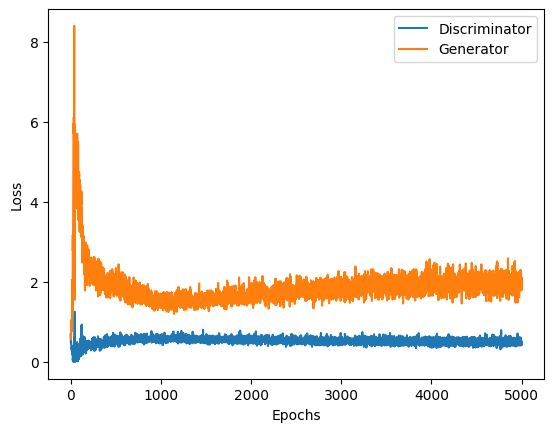

In [31]:
plt.plot(d_loss_all)
plt.plot(g_loss_all)
plt.legend(('Discriminator','Generator'))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## **Generate Images**

4/4 [==============================] - 0s 8ms/step


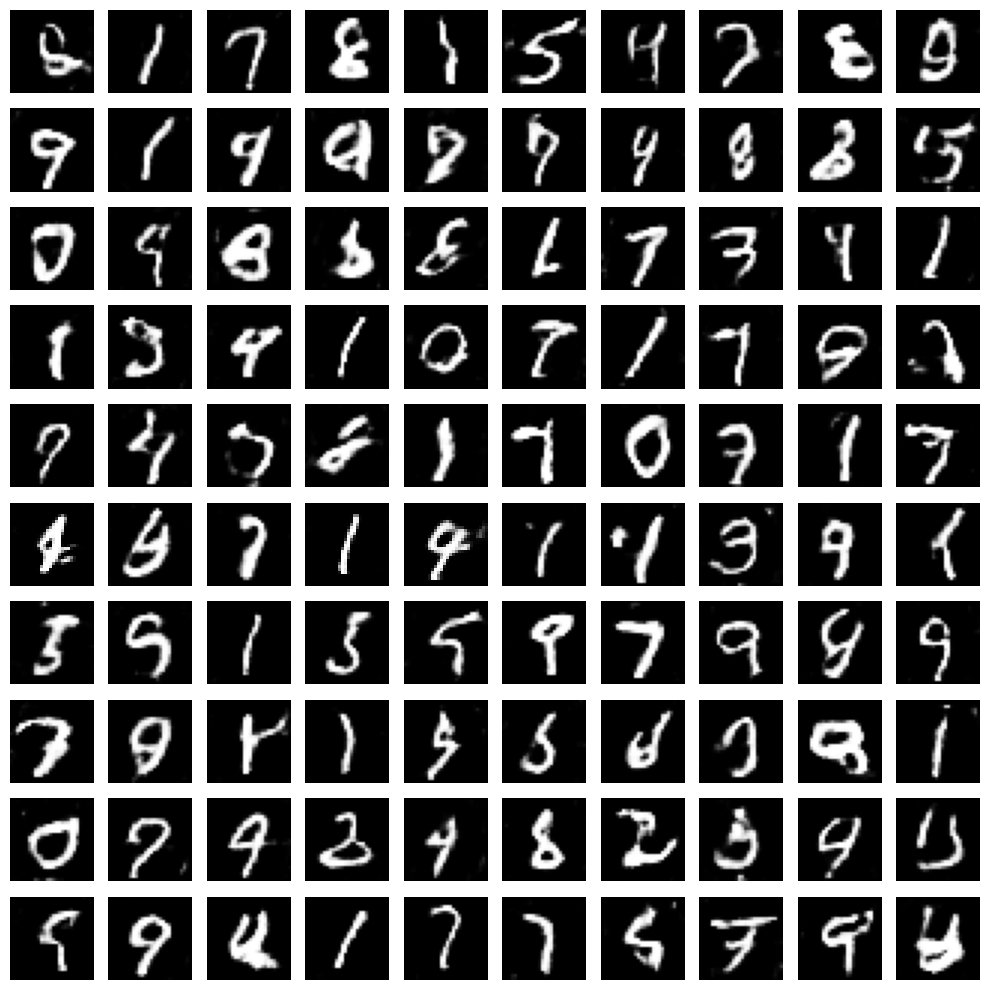

In [32]:
# Generate images
noise = np.random.normal(0, 1, (100, 100))
generated_images = generator.predict(noise)

# Display generated images
plt.figure(figsize=(10, 10))
for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.imshow(generated_images[i, :, :, 0], cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
import glob

# Create animation
fig = plt.figure()
images = []
for filename in sorted(glob.glob('images/*.png')):
    img = plt.imread(filename)
    im = plt.imshow(img, animated=True)
    images.append([im])

ani = animation.ArtistAnimation(fig, images, interval=1000, blit=True, repeat_delay=1000)
plt.show()


## **Conclusion**

Generative Adversarial Networks (GANs) represent a powerful paradigm in the field of machine learning, offering diverse applications and functionalities. GANs have demonstrated remarkable capabilities in generating realistic data, enhancing image processing, and facilitating creative applications. Despite their effectiveness, challenges such as mode collapse and training instability persist, necessitating ongoing research efforts. Nevertheless, with proper understanding and implementation, GANs hold immense potential to revolutionize various domains, as exemplified by their practical utilization on the MNIST datasets.